In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound
from celmech.disturbing_function import laplace_b

In [2]:
from celmech.secular import LaplaceLagrangeSystem
from celmech.poincare import Poincare

In [3]:
def make_sim(alpha, mass, ecc, pom):
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)
    mu1, mu2, mu3 = mass
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    return sim

In [4]:
def run(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
    Gx, Gy = np.zeros((Nout,3)), np.zeros((Nout,3))
    for i, time in enumerate(times):
        sim.integrate(time)
        Gx[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.cos(-p.pomega) for p in ps[1:]]
        Gy[i] = [np.sqrt(2*p.m*np.sqrt(sim.G*ps[0].m*p.a)*(1-np.sqrt(1-p.e**2)))*np.sin(-p.pomega) for p in ps[1:]]
    
    Sx = T.T @ Gx.T
    Sy = T.T @ Gy.T
    
    #print(Mdiag)
    #print(T.T)
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    R2 = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])
    
    w2 = m1*m2/ec23**2 + m2*m3/ec12**2 + (m1+m3)**2/ec13**2
    w3 = m_tot * (m3/ec23**2 + m1/ec12**2)
    k = np.sqrt(m1*m2*m3*m_tot) * (1/ec23**2 - 1/ec12**2)
    
    #w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    #w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    #k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    
    #r = (1-alpha12)/(1-alpha13)
    #z = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (1/(1-r)**2 - 1/r**2) /ec13**2
    #x = m2/(m1+m3) * (m1/(1-r)**2 + m3/r**2) / ec13**2 + (m1+m3) / ec13**2
    #y = m_tot/(m1+m3) * (m1/r**2 + m3/(1-r)**2)/ec13**2
    #print(k/(w2-w3), z/(x-y))
    phi = 1/2*np.arctan2(2*k, w2-w3) - np.pi/2
    R1 = np.array([[1, 0, 0],
                [0, np.cos(phi), np.sin(phi)],
                [0, -np.sin(phi), np.cos(phi)]])
    R = np.matmul(R1, R2)
    print(phi)
    
    print(T.T)
    print(R2.T)
    
    print(R1)
    Sxapprox = R.T @ Gx.T
    Syapprox = R.T @ Gy.T
    
    G1, G2, G3 = np.sqrt(Gx**2 + Gy**2).T
    S1, S2, S3 = np.sqrt(Sx**2 + Sy**2)
    S1a, S2a, S3a = np.sqrt(Sxapprox**2 + Syapprox**2)
    
    return times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a

In [5]:
def norun(sim):
    ps = sim.particles
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    Mdiag = T.T @ lsys.Neccentricity_matrix @ T
    
    ec13 = 1-ps[1].a/ps[3].a
    m_tot = ps[1].m + ps[2].m + ps[3].m
    Tsec = 2*np.pi/(1/2*m_tot/ps[0].m/ec13**2)*ps[1].P
    
    Nout = 1000
    times = np.linspace(0,2*Tsec, Nout)
     
    #print(T.T)
    
    m1, m2, m3 = ps[1].m, ps[2].m, ps[3].m
    alpha12, alpha23 = ps[1].a/ps[2].a, ps[2].a/ps[3].a
    alpha13 = alpha12*alpha23
    ec12, ec23, ec13 = 1-alpha12, 1-alpha23, 1-alpha13
    
    #print(M[2,1])
    #print('*-*', np.pi/2*np.sqrt(ps[2].m*ps[3].m)*laplace_b(3/2, 2, 0, alpha23)*alpha23**(9/4))
    
    print(M[2,0])
    print('*-*', np.pi/2*np.sqrt(ps[1].m*ps[3].m)*laplace_b(3/2, 2, 0, alpha13)*alpha13*alpha12**(-1/4)*alpha23**(5/4))
    
    R2 = np.array([[np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)],
                   [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
                   [np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)]])
    
    #ec12 = np.sqrt(2/np.pi/laplace_b(3/2, 1, 0, alpha12))
    #ec23 = np.sqrt(2/np.pi/laplace_b(3/2, 1, 0, alpha23))
    #ec13 = np.sqrt(2/np.pi/laplace_b(3/2, 1, 0, alpha13))
    massprefac = -1/(m1+m3)
    w2 = massprefac*(m1*m2/ec23**2 + m2*m3/ec12**2 + (m1+m3)**2/ec13**2)
    w3 = massprefac*(m_tot * (m3/ec23**2 + m1/ec12**2))
    k = massprefac * np.sqrt(m1*m2*m3*m_tot) * (1/ec23**2 - 1/ec12**2)
    
    delta = (laplace_b(3/2, 1, 0, alpha13)-laplace_b(3/2, 2, 0, alpha13))/laplace_b(3/2, 1, 0, alpha13)
    kcorr = delta*laplace_b(3/2, 1, 0, alpha13)*massprefac*np.sqrt(m1*m2*m3*m_tot)*(m1-m3)/(m_tot)
    print('***', (1/ec23**2 - 1/ec12**2), (m1-m3)/(m_tot)*laplace_b(3/2, 1, 0, alpha13)-laplace_b(3/2, 2, 0, alpha13))
    #w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    #w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    #k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    
    #r = (1-alpha12)/(1-alpha13)
    #z = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (1/(1-r)**2 - 1/r**2) /ec13**2
    #x = m2/(m1+m3) * (m1/(1-r)**2 + m3/r**2) / ec13**2 + (m1+m3) / ec13**2
    #y = m_tot/(m1+m3) * (m1/r**2 + m3/(1-r)**2)/ec13**2
    #print(k/(w2-w3), z/(x-y))
    phi = 1/2*np.arctan2(2*k, w2-w3)# - np.pi/2
    R1 = np.array([[1, 0, 0],
                [0, np.cos(phi), np.sin(phi)],
                [0, -np.sin(phi), np.cos(phi)]])
    R = np.matmul(R1, R2)
    #print(phi)
    print(Mdiag)
    Mdiagapprox = R2 @ lsys.Neccentricity_matrix @ R2.T
    print(Mdiagapprox)
    
    print('w3:', Mdiagapprox[0,0], w3, (Mdiagapprox[0,0]-w3)/Mdiagapprox[0,0])
    print('w2:', Mdiagapprox[1,1], w2, (Mdiagapprox[1,1]-w2)/Mdiagapprox[1,1])
    print('w2-w3:', Mdiagapprox[1,1]-Mdiagapprox[0,0], w2-w3, ((Mdiagapprox[1,1]-Mdiagapprox[0,0])-(w2-w3))/(Mdiagapprox[1,1]-Mdiagapprox[0,0]))
    print('k:', Mdiagapprox[1,0], k, (Mdiagapprox[1,0]-k)/Mdiagapprox[1,0])
    tanphi = 2*Mdiagapprox[1,0]/(Mdiagapprox[1,1]-Mdiagapprox[0,0])
    print('kcorr:', kcorr)
    print('tan phi:', tanphi, 2*k/(w2-w3), (tanphi-2*k/(w2-w3))/tanphi)
    
    
    #print(T.T)
    #print(R2)
    
    #print(R1)

w3 top left, w2 middle, k 1,0, 0,1. Mdiag and Eq 14 now match for high alpha. 

In [6]:
alpha13 = 0.5
delta = (laplace_b(3/2, 1, 0, alpha13)-laplace_b(3/2, 2, 0, alpha13))/laplace_b(3/2, 1, 0, alpha13)
delta*laplace_b(3/2, 1, 0, alpha13)

1.022473586273209

In [7]:
print(laplace_b(3/2, 1, 0, 0.5)-laplace_b(3/2, 2, 0, 0.5))
print(laplace_b(3/2, 1, 0, 0.75)-laplace_b(3/2, 2, 0, 0.75))

1.022473586273209
1.5594204559900398


In [8]:
print(laplace_b(3/2, 1, 0, 0.5)/laplace_b(3/2, 1, 0, 0.75))
print(laplace_b(3/2, 2, 0, 0.5)/laplace_b(3/2, 2, 0, 0.75))


0.2376896786783952
0.1675806797087533


In [9]:
print(laplace_b(3/2, 1, 0, 0.5),laplace_b(3/2, 2, 0, 0.5))

2.5805000300273377 1.5580264437541287


In [10]:

alpha = 0.75
print((laplace_b(3/2, 1, 0, alpha)-2/np.pi/(1-alpha)**2)/laplace_b(3/2, 1, 0, alpha))
print((laplace_b(3/2, 2, 0, alpha)-2/np.pi/(1-alpha)**2)/laplace_b(3/2, 2, 0, alpha))
print((laplace_b(3/2, 1, 0, alpha)-laplace_b(3/2, 2, 0, alpha))/laplace_b(3/2, 1, 0, alpha))

0.061775951180993695
-0.0955929493707825
0.14363810997702733


# We match celmech only if we use 1/2 M def in Eq 19 of T21. This is not what's in the LL example and Sam said there should be no 1/2. Check Hamilton's Eqs in complex matrix coordinates

# For test particle case, R still diagonalizes and matches LL solution almost perfectly, but w2, w3 are off. 

# ecross approximations are fine, must be difference between b1 and b2 coefficients $\sim \delta$?

In [22]:
%%time
alpha = 0.75, 0.85 #0.735, 0.735
mass = 2e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
ps = sim.particles
print(sim.G, sim.particles[0].m, sim.particles[2].a, ps[2].n/2/np.pi)
#print(sim.particles[2].n)
#print(laplace_b(3/2, 2, 0, alpha[0])*np.sqrt(mass[0]*mass[1])*sim.particles[2].n/4/sim.particles[0].m)
norun(sim)

39.476926421373 1.0 0.9999875091381175 1.0000000000000002
4.785392802190383e-07
*-* 4.785389509049127e-07
*** 28.44443085433058 -2.5689905351149305
[[-8.31198422e-06 -2.50074180e-22 -5.16481274e-22]
 [-1.96310991e-23 -3.10505711e-06 -4.90874885e-23]
 [-4.63924753e-22  1.03649275e-22 -4.20043578e-07]]
[[-7.68868048e-06 -1.68874977e-06  7.28973894e-08]
 [-1.68874977e-06 -3.72502065e-06  1.04110883e-07]
 [ 7.28973894e-08  1.04110883e-07 -4.23383783e-07]]
w3: -7.688680478681405e-06 -1.0192589500577942e-05 -0.3256617346551449
w2: -3.725020647176433e-06 -5.779290967783881e-06 -0.5514789084899666
w2-w3: 3.963659831504972e-06 4.41329853279406e-06 -0.11344028509085355
k: -1.6887497668762333e-06 -2.6817666592118685e-06 -0.5880189663460142
kcorr: -3.023830697149758e-08
tan phi: -0.8521163967973647 -1.215311694545187 -0.4262273312811171
CPU times: user 71.4 ms, sys: 5.28 ms, total: 76.7 ms
Wall time: 74 ms


In [12]:
%%time
alpha = 0.75, 0.85 #0.735, 0.735
mass = 2e-7,1e-7,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)
print(sim.particles[2].n)
print(laplace_b(3/2, 2, 0, alpha[0])*np.sqrt(mass[0]*mass[1])*sim.particles[2].n/4/sim.particles[0].m)
norun(sim)

6.283185307179587
2.06531239644841e-06
4.785392802190383e-07
*-* 4.785389509049127e-07
*** 28.44443085433058 -2.5689905351149305
[[-8.31198422e-06 -2.50074180e-22 -5.16481274e-22]
 [-1.96310991e-23 -3.10505711e-06 -4.90874885e-23]
 [-4.63924753e-22  1.03649275e-22 -4.20043578e-07]]
[[-7.68868048e-06 -1.68874977e-06  7.28973894e-08]
 [-1.68874977e-06 -3.72502065e-06  1.04110883e-07]
 [ 7.28973894e-08  1.04110883e-07 -4.23383783e-07]]
w3: -7.688680478681405e-06 -1.0192589500577942e-05 -0.3256617346551449
w2: -3.725020647176433e-06 -5.779290967783881e-06 -0.5514789084899666
w2-w3: 3.963659831504972e-06 4.41329853279406e-06 -0.11344028509085355
k: -1.6887497668762333e-06 -2.6817666592118685e-06 -0.5880189663460142
kcorr: -3.023830697149758e-08
tan phi: -0.8521163967973647 -1.215311694545187 -0.4262273312811171
CPU times: user 67.9 ms, sys: 4.59 ms, total: 72.5 ms
Wall time: 70.4 ms


In [13]:
from sympy import *
init_printing()
m1, m2, m3, Mstar, e12, e23, e13, b1_12, b1_23, b1_13, b2_12, b2_23, b2_13, alpha12, alpha23, alpha13 = symbols("m1, m2, m3, Mstar, e_{12}, e_{23}, e_{13}, b1_{12}, b1_{23}, b1_{13}, b2_{12}, b2_{23}, b2_{13}, a_{12}, a_{23}, a_{13}", positive=True, real=True)

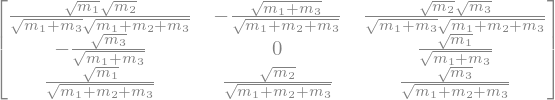

In [14]:
R = Matrix([[sqrt(m1*m2/(m1+m3)/(m1+m2+m3)), -sqrt((m1+m3)/(m1+m2+m3)), sqrt(m2*m3/(m1+m3)/(m1+m2+m3))],
                 [-sqrt(m3/(m1+m3)), 0, sqrt(m1/(m1+m3))], 
                 [sqrt(m1/(m1+m2+m3)), sqrt(m2/(m1+m2+m3)), sqrt(m3/(m1+m2+m3))]])
R

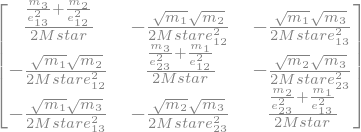

In [15]:
M = 1/(2*Mstar)*Matrix([[m2/e12**2 + m3/e13**2, -sqrt(m1*m2)/e12**2, -sqrt(m1*m3)/e13**2],
                 [-sqrt(m1*m2)/e12**2, m1/e12**2 + m3/e23**2, -sqrt(m2*m3)/e23**2], 
                 [-sqrt(m1*m3)/e13**2, -sqrt(m2*m3)/e23**2, m1/e13**2 + m2/e23**2]])
M

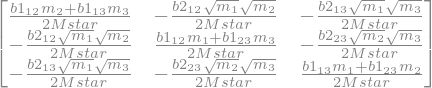

In [16]:
Mfull = 1/(2*Mstar)*Matrix([[m2*b1_12 + m3*b1_13, -sqrt(m1*m2)*b2_12, -sqrt(m1*m3)*b2_13],
                 [-sqrt(m1*m2)*b2_12, m1*b1_12 + m3*b1_23, -sqrt(m2*m3)*b2_23], 
                 [-sqrt(m1*m3)*b2_13, -sqrt(m2*m3)*b2_23, m1*b1_13 + m2*b1_23]])
Mfull

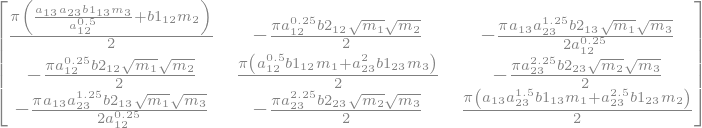

In [17]:
Mfullalpha = pi/2*Matrix([[m2*b1_12 + alpha13*alpha23*alpha12**(-1/2)*m3*b1_13, -alpha12**(1/4)*sqrt(m1*m2)*b2_12, -alpha13*alpha12**(-1/4)*alpha23**(5/4)*sqrt(m1*m3)*b2_13],
                 [-alpha12**(1/4)*sqrt(m1*m2)*b2_12, alpha12**(1/2)*m1*b1_12 + alpha23**2*m3*b1_23, -alpha23**(9/4)*sqrt(m2*m3)*b2_23], 
                 [-alpha13*alpha12**(-1/4)*alpha23**(5/4)*sqrt(m1*m3)*b2_13, -alpha23**(9/4)*sqrt(m2*m3)*b2_23, alpha13*alpha23**(3/2)*m1*b1_13 + alpha23**(5/2)*m2*b1_23]])
Mfullalpha

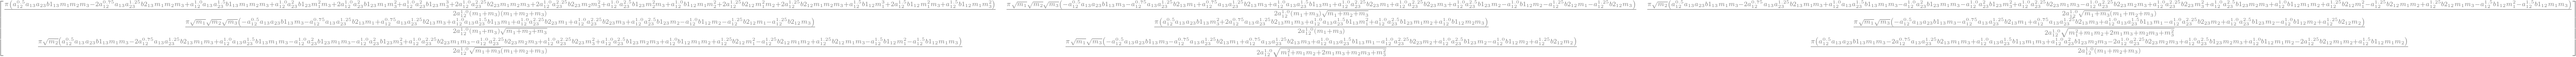

In [23]:
res = simplify(R*Mfullalpha*R.T)
res = Matrix([[simplify(factor(res[i,j])) for i in range(3)] for j in range(3)])
res

This works when we replace the laplace coefficients with ecross's. Real expression is more complicated because there are two types of laplace coefficients

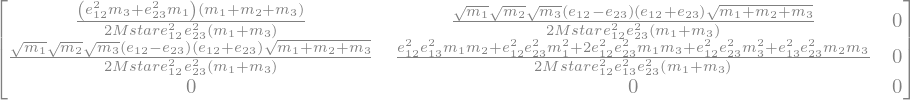

In [18]:
res = simplify(R*M*R.T)
res = Matrix([[simplify(factor(res[i,j])) for i in range(3)] for j in range(3)])
res

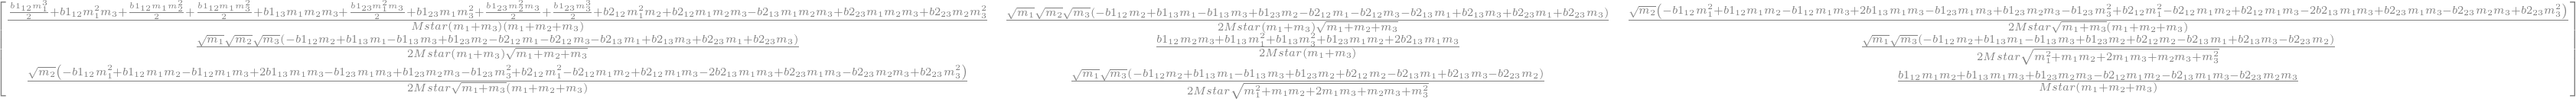

In [19]:
res = simplify(R*Mfull*R.T)
res = Matrix([[simplify(factor(res[i,j])) for i in range(3)] for j in range(3)])
res

In [20]:
%%time
alpha = 0.905, 0.905 #0.735, 0.735
mass = 1e-7,1e-16,1e-7
ecc = 0.005, 0.005, 0.005
pomega = 0, 0, np.pi
sim = make_sim(alpha, mass, ecc, pomega)

times, G1, G2, G3, S1, S2, S3, S1a, S2a, S3a = run(sim)

-7.050352079929212e-09
[[ 1.71297102e-05 -1.00000000e+00  1.39040699e-05]
 [ 7.26164912e-01  2.87966062e-06 -6.87520560e-01]
 [ 6.87520560e-01  2.18736756e-05  7.26164912e-01]]
[[ 7.07106781e-01 -7.07106781e-01  1.58113883e-05]
 [ 2.23606798e-05  0.00000000e+00 -1.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  1.58113883e-05]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -7.05035208e-09]
 [ 0.00000000e+00  7.05035208e-09  1.00000000e+00]]
CPU times: user 22.9 s, sys: 1.65 s, total: 24.5 s
Wall time: 22.5 s


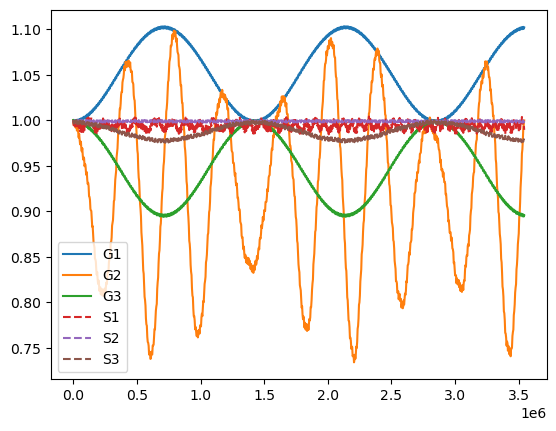

In [21]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1/S1[0], linestyle='--', label='S1')
ax.plot(times, S2/S2[0], linestyle='--', label='S2')
ax.plot(times, S3/S3[0], linestyle='--', label='S3')
#ax.plot(times, S1a/S1a[0], linestyle='-.', label='S1a')
#ax.plot(times, S2a/S2a[0], linestyle='-.', label='S2a')
#ax.plot(times, S3a/S3a[0], linestyle='-.', label='S3a')
ax.legend()

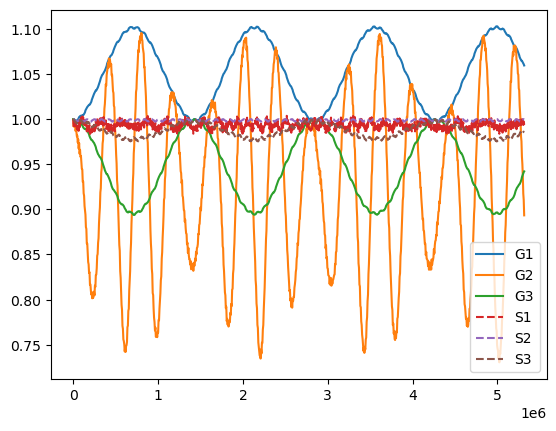

In [147]:
fig, ax = plt.subplots()
ax.plot(times, G1/G1[0], label='G1')
ax.plot(times, G2/G2[0], label='G2')
ax.plot(times, G3/G3[0], label='G3')
ax.plot(times, S1/S1[0], linestyle='--', label='S1')
ax.plot(times, S2/S2[0], linestyle='--', label='S2')
ax.plot(times, S3/S3[0], linestyle='--', label='S3')
#ax.plot(times, S1a/S1a[0], linestyle='-.', label='S1a')
#ax.plot(times, S2a/S2a[0], linestyle='-.', label='S2a')
#ax.plot(times, S3a/S3a[0], linestyle='-.', label='S3a')
ax.legend()

In [3]:
def eccMatrix(alpha, mass):
    mu1, mu2, mu3 = mass
    alpha12, alpha23 = alpha
    P1, P2, P3 = alpha12**(3/2), 1, 1/alpha23**(3/2)

    sim = rb.Simulation()
    sim.add(m=1.)
    sim.add(m=mu1, P=P1)
    sim.add(m=mu2, P=P2)
    sim.add(m=mu3, P=P3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    align_simulation(sim)
    
    pvars = Poincare.from_Simulation(sim)
    alpha12 = pvars.particles[1].a/pvars.particles[2].a
    alpha23 = pvars.particles[2].a/pvars.particles[3].a
    alpha13 = pvars.particles[1].a/pvars.particles[3].a
#     print(f"alpha = {alpha12, alpha23, alpha13}")

    lsys = LaplaceLagrangeSystem.from_Simulation(sim)  
    M = lsys.Neccentricity_matrix
#     print(f"eccentricity matrix =")
#     print(M)
    
    return M

In [ ]:
def sec(sim):
    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    ps = sim.particles
    res = {}
    pvars = Poincare.from_Simulation(sim)
    res['Lambda'] = np.array([p.Lambda for p in pvars.particles[1:]])
    res['Gamma'] = np.array([p.Gamma for p in pvars.particles[1:]])
    res['Gammax'] = np.sqrt(2*res['Gamma'])*np.cos([p.gamma for p in pvars.particles[1:]]) # gamma = -pomega
    res['Gammay'] = np.sqrt(2*res['Gamma'])*np.sin([p.gamma for p in pvars.particles[1:]])
    res['M'] = lsys.Neccentricity_matrix # no longer normalized
    return res

def LLsoln(M, Gx0, Gy0, times):
    vals,T = np.linalg.eigh(M) # T returned by eigh is R^T in paper. Could define R = T.T
    freqs = np.diag(np.diag(vals))
    Ax0 = T.T @ Gx0
    Ay0 = T.T @ Gy0
    print(Ax0)
    print(Ay0)
    
    cos_vals = np.array([np.cos(freq * times) for freq in freqs]).T
    sin_vals = np.array([np.sin( freq * times) for freq in freqs]).T
    Ax = Ax0 * cos_vals - Ay0 * sin_vals    
    Ay = Ax0 * sin_vals + Ay0 * cos_vals
    Gx = np.transpose(T @ Ax.T).T
    Gy = np.transpose(T @ Ay.T).T
    
    return Gx, Gy

def GToS(sim, R):
    pvars = Poincare.from_Simulation(sim)
    Gx = np.sqrt([2*p.Gamma for p in pvars.particles[1:]])*np.cos([p.gamma for p in pvars.particles[1:]])
    Gy = np.sqrt([2*p.Gamma for p in pvars.particles[1:]])*np.sin([p.gamma for p in pvars.particles[1:]])
    Sx = R.T @ Gx
    Sy = R.T @ Gy
    return np.sqrt(Sx**2 + Sy**2)

In [4]:
def eccMatrix_diag(alpha, mass):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    
    R2 = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])
    M = eccMatrix(alpha, mass)
    
    w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    
    r = (1-alpha12)/(1-alpha13)
    e13 = 1-alpha13
    z = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (1/(1-r)**2 - 1/r**2) /e13**2
    x = m2/(m1+m3) * (m1/(1-r)**2 + m3/r**2) / e13**2 + (m1+m3) / e13**2
    y = m_tot/(m1+m3) * (m1/r**2 + m3/(1-r)**2)/e13**2
    print(k/(w2-w3), z/(x-y))
    phi = 1/2*np.arctan2(2*k, w2-w3) - np.pi/2
    R1 = np.array([[1, 0, 0],
                [0, np.cos(phi), np.sin(phi)],
                [0, -np.sin(phi), np.cos(phi)]])
    R = np.matmul(R1, R2)
    print(np.matmul(np.matmul(R2, M), np.transpose(R2)))
    print(f'sin(phi)={np.sin(phi)}, approx={k/(w2-w3)}')
    
#     vals, k = np.linalg.eigh(M)
    
    return np.matmul(np.matmul(R, M), np.transpose(R))

In [5]:
x = eccMatrix_diag((0.8,0.93), (1e-8, 1e-8, 1e-9))
print(x)
# print(f"sine = {np.sin(psi)}, cosine = {np.cos(psi)}")
# print(f"sine = {k/delta}, cosine = {np.sqrt(1-(k/delta)**2)}")

0.6327937148848662 0.6110981584964722
[[-2.70710701e-08  5.75325564e-09 -9.25279132e-09]
 [ 5.75325564e-09 -1.73185836e-06 -6.39609502e-07]
 [-9.25279132e-09 -6.39609502e-07 -7.44854925e-07]]
sin(phi)=-0.8999915688470261, approx=0.6327937148848662
[[-2.70710701e-08  1.08353203e-08  1.14452227e-09]
 [ 1.08353203e-08 -4.30546443e-07  9.32430117e-09]
 [ 1.14452227e-09  9.32430117e-09 -2.04616684e-06]]


/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:2002: FutureWarning: sim.calculate_angular_momentum() is deprecated and will be removed in the future. Use sim.angular_momentum() instead
  warnings.warn( "sim.calculate_angular_momentum() is deprecated and will be removed in the future. Use sim.angular_momentum() instead", FutureWarning)


In [6]:
k, delta

NameError: name 'k' is not defined

In [ ]:
np.arctan(0.23)

In [ ]:
np.arctan2(0.23, 1)